# Python for HPC

## Max Planck Computing and Data Facility, Garching

# Exercises for parallel applications

## Amdahl's law
* Plot Amdahl's law for serial fractions of $f=0.1, 0.01, 0.001$
* What is the maximum speed-up for a serial fraction of 10%, 1%, and 0.1%? How many processors are worth using in each case at a maximum?

In [1]:
# for solution, see lecture notebook

## `Pool` class
* Goal: try get_edges filter from lecture for different parameters
* Use a `Pool` class with `Pool.map` to compute the filters in parallel
* Plot all the different results in one graph
* Compare the timings of the parallel and a serial algorithm (you can compare `Pool.map` with `list(map(my_function, parameter_list))` as a serial map)

In [4]:
import numpy as np
# from lecture:
from scipy.misc import ascent
def get_edges(percentiles=(25, 99)):
    image = ascent()
    result = np.zeros_like(image)
    N, M = image.shape
    result[1:N-1, 1:M-1] = -1.0*(image[0:N-2, 1:M-1] + image[2:N, 1:M-1]
                                 + image[1:N-1, 0:M-2] + image[1:N-1, 2:M]
                                 + image[0:N-2, 0:M-2] + image[0:N-2, 2:M]
                                 + image[2:N, 0:M-2] + image[2:N, 2:M]) \
        + 8.*image[1:N-1, 1:M-1]
    # now truncate results
    fmin, fmax = np.percentile(result, percentiles)
    result[result < fmin] = fmin
    result[result > fmax] = fmax
    return result

percentiles = [(25, 99), (25, 90), (30, 95), (1, 99), (1, 20), (5, 30)]

from multiprocessing import Pool
with Pool(3) as p:
    results = p.map(get_edges, percentiles)

    %timeit p.map(get_edges, percentiles)
    %timeit list(map(get_edges, percentiles))

128 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
243 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


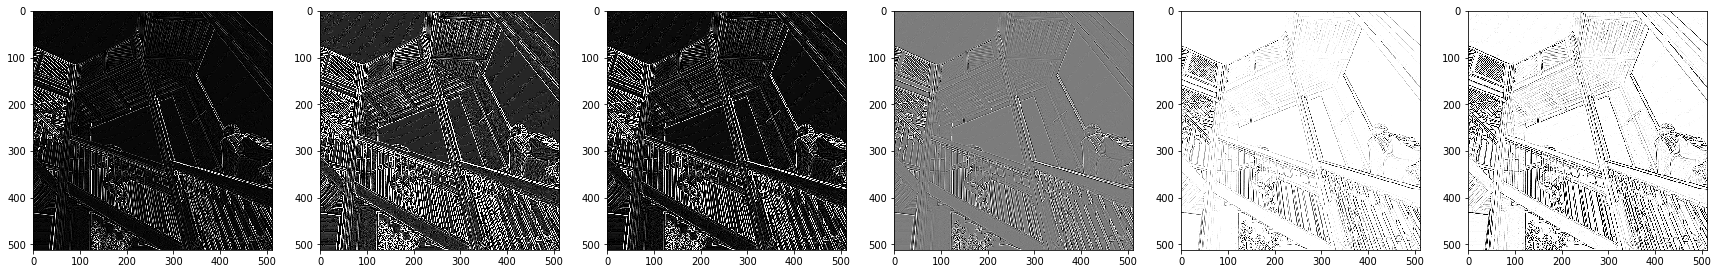

In [4]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1, len(results), figsize=(5*len(results), 5))
for ax, image in zip(axs, results):
    ax.imshow(image, cmap='gray')

## `Pool` class II
* Goal: parallelize computation of $\pi$ with Monte Carlo method (see NumPy exercises for serial implementation)
* Divide total number of wanted trials into chunks
* Use `Pool.map` on the array of chunk sizes to get $\pi$ for each chunk size as a specific Monte Carlo realization
* Average results from each chunk to get final result
* Compare timings to ensure you benefit from the parallelization

In [5]:
# function for computing pi
def get_pi_montecarlo(number_trials):
    # first generate a random number array of size (number_trials, 2)
    numbers = np.random.rand(number_trials, 2)
    # now compute the radius of each of these positions
    radius = np.sqrt(np.sum(numbers**2, axis=1))
    # create a boolean array to select all radii below 1.0
    in_circle = radius <= 1.0
    # compute the number of points in this circle
    number_in_circle = in_circle.sum()
    # compute the approximation to pi
    approximate_pi = 4.*number_in_circle/number_trials
    return approximate_pi

from multiprocessing import Pool
with Pool(6) as p:
    chunks = np.array([10**5] * 100)
    results = p.map(get_pi_montecarlo, chunks)
    pi = np.mean(results)
    print("Final result: {:f}".format(pi))

    %timeit p.map(get_pi_montecarlo, chunks)
    %timeit list(map(get_pi_montecarlo, chunks))

Final result: 3.141710
124 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
431 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MPI
1. Write a little ping-pong program: 2 processes send and receive in turn and print information when they send or receive
2. Implement a ring communication: a message is always passed to the right neighbor until it arrives at the root process again
3. Implement a scatter+gather program: create an array of the numbers from 0 to N (choose N to be a multiple of the number of processors); use scatter to distribute this array to all processes; multiply the numbers locally with the local rank index (or with $10^{rank}$); gather the array to the root process; print the array on the root process; possible extension: try Allgather and print on all ranks
4. Compute an average over an array by combining scatter and reduce: distribute the array with scatter; compute the sum of the elements on each rank; use reduce to compute the total sum on rank 0; divide by total number of elements and print on rank 0; possible extension: try Allreduce and print on all ranks
5. Define an array on each rank using a block data decomposition for an arbitrary array size N; print the local indices; possible extension: use the Scatterv and Gatherv functions to communicate the full array from/to rank 0, similar to 3.; hint: the Gatherv and Scatterv take as arguments a send buffer and a receive buffer that are either `[data, count, MPI.DOUBLE]` or  `[data, counts, displacements, MPI.DOUBLE]` (the first is for the arrays local to each core, the second for the array to be scattered from/gathered to the root rank; counts is an integer array with the sizes on each core, displacements an integer array with the starting positions of the data on each core in the final array)